In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import matplotlib as mpl

%matplotlib inline



from IPython.display import display 

In [2]:
pd.set_option('display.max_columns',0)

In [3]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,78100.0,78200.0,78400.0,78600.0,78800.0,79000.0,79100.0,79200.0,79300.0,79300.0,79300.0,79400.0,79500.0,79500.0,79600.0,...,114700,115000,115000,115200,115600,115900,115600,115400,115400,115500,115800,116300,116200,115600,115000,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# get_model_metrics(true, preds, train, explain_U=False)
        
#         get_train_test_split_index(ts, TEST_SIZE=0.2)
    
#         make_dateindex(df_to_add_index, index_col='Month', index_name='date', drop=True, freq=None, verbose=True)
    
#         melt_data(df)
    
#         meta_grid_search(ts, TEST_SIZE=0.2, model_kws={}, verbose=True, return_kws=False)
    
#         plotly_timeseries(df, x='datetime', y='MeanValue', color='RegionID', line_group='State')
    
#         stationarity_check(TS, plot=True, col=None)
#             From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    
#         thiels_U(ys_true=None, ys_pred=None, display_equation=True, display_table=True)
#             Calculate's Thiel's U metric for forecasting accuracy.
#             Accepts true values and predicted values.
#             Returns Thiel's U

In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
                                    'SizeRank'],var_name = 'Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset = ['MeanValue'])
    return melted

In [6]:
df = melt_data(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [7]:

def make_dateindex(df, index_col='Month', drop = False, verbose = True):

    
    # Make datetime column which will become the index
    df[index_col] = pd.to_datetime(df[index_col], errors = 'coerce')
    
    
    # assign index
    df = df.set_index('Month', drop = drop)
    
    # Ask about what this means
    
    if verbose:
        display(df.index)
    return df

df = make_dateindex(df)
df

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
...,...,...,...,...,...,...,...,...,...
2018-04-01,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04-01,209300.0
2018-04-01,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04-01,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04-01,133400.0


In [8]:
df = df.rename(columns = {'Month':'Date',})

In [9]:
cali_df = df.loc[df['State'] == 'CA']
len(cali_df)

318744

In [10]:
cali_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0
1996-04-01,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,1996-04-01,152500.0
1996-04-01,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,1996-04-01,139200.0
1996-04-01,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,1996-04-01,340600.0
1996-04-01,97711,94501,Alameda,CA,San Francisco,Alameda,65,1996-04-01,222400.0


In [11]:
cali_df.isna().sum()

RegionID          0
RegionName        0
City              0
State             0
Metro         10602
CountyName        0
SizeRank          0
Date              0
MeanValue         0
dtype: int64

In [12]:
sacramento_df = df.loc[df['City'] == 'Sacramento']
sacramento_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,98432,95823,Sacramento,CA,Sacramento,Sacramento,147,1996-04-01,91500.0
1996-04-01,98440,95831,Sacramento,CA,Sacramento,Sacramento,922,1996-04-01,162600.0
1996-04-01,98431,95822,Sacramento,CA,Sacramento,Sacramento,1259,1996-04-01,85300.0
1996-04-01,98442,95833,Sacramento,CA,Sacramento,Sacramento,2111,1996-04-01,105300.0
1996-04-01,98451,95843,Sacramento,CA,Sacramento,Sacramento,2123,1996-04-01,130200.0


In [13]:
sacramento = {}
for zipcode in sacramento_df['RegionName'].unique():
    temp = sacramento_df.groupby('RegionName').get_group(zipcode)
    sacramento[zipcode] = temp.resample('MS').asfreq()

[95823, 95831, 95822, 95833, 95843, 95835, 95820, 95842, 95838, 95660, 95834, 95816, 95818, 95824, 95829, 95841, 95819, 95817, 95811, 95832, 95815]


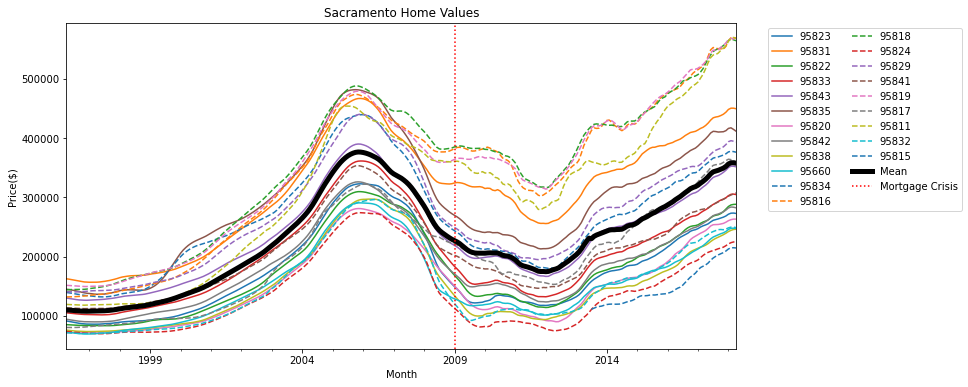

In [14]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
        crash = '01-2009'
        ax.axvline(crash, label = 'Mortgage Crisis', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'Sacramento Home Values', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict1 = plot_value(sacramento)

In [15]:
visalia_df = df.loc[df['City'] == 'Visalia']
visalia_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,97205,93277,Visalia,CA,Visalia,Tulare,866,1996-04-01,108100.0
1996-04-01,97215,93291,Visalia,CA,Visalia,Tulare,1074,1996-04-01,101800.0
1996-04-01,97216,93292,Visalia,CA,Visalia,Tulare,2537,1996-04-01,118700.0
1996-05-01,97205,93277,Visalia,CA,Visalia,Tulare,866,1996-05-01,107700.0
1996-05-01,97215,93291,Visalia,CA,Visalia,Tulare,1074,1996-05-01,101900.0


In [16]:
visalia = {}
for zipcode in visalia_df['RegionName'].unique():
    temp = visalia_df.groupby('RegionName').get_group(zipcode)
    visalia[zipcode] = temp.resample('MS').asfreq()

[93277, 93291, 93292]


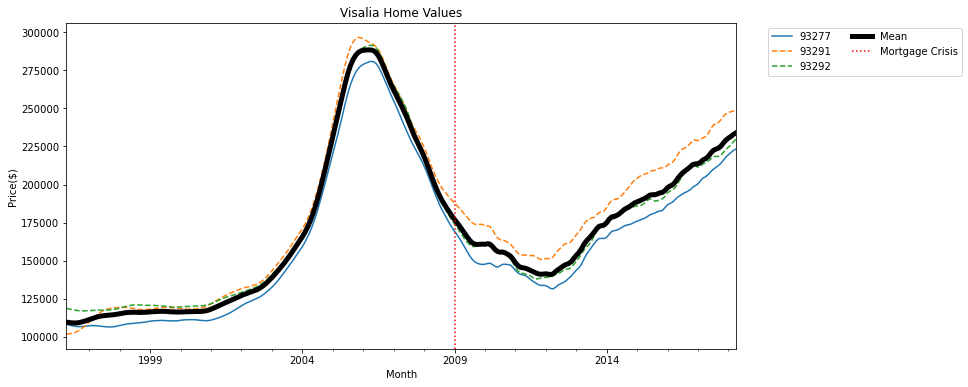

In [17]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
        crash = '01-2009'
        ax.axvline(crash, label = 'Mortgage Crisis', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'Visalia Home Values', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict2 = plot_value(visalia)

In [18]:
salinas_df = df.loc[df['City'] == 'Salinas']
salinas_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,97471,93906,Salinas,CA,Salinas,Monterey,1176,1996-04-01,161600.0
1996-04-01,97470,93905,Salinas,CA,Salinas,Monterey,2683,1996-04-01,138300.0
1996-04-01,97468,93901,Salinas,CA,Salinas,Monterey,4270,1996-04-01,181200.0
1996-04-01,97472,93907,Salinas,CA,Salinas,Monterey,6123,1996-04-01,206300.0
1996-04-01,97473,93908,Salinas,CA,Salinas,Monterey,7877,1996-04-01,319400.0


In [19]:
salinas = {}
for zipcode in salinas_df['RegionName'].unique():
    temp = salinas_df.groupby('RegionName').get_group(zipcode)
    salinas[zipcode] = temp.resample('MS').asfreq()
    

[93906, 93905, 93901, 93907, 93908]


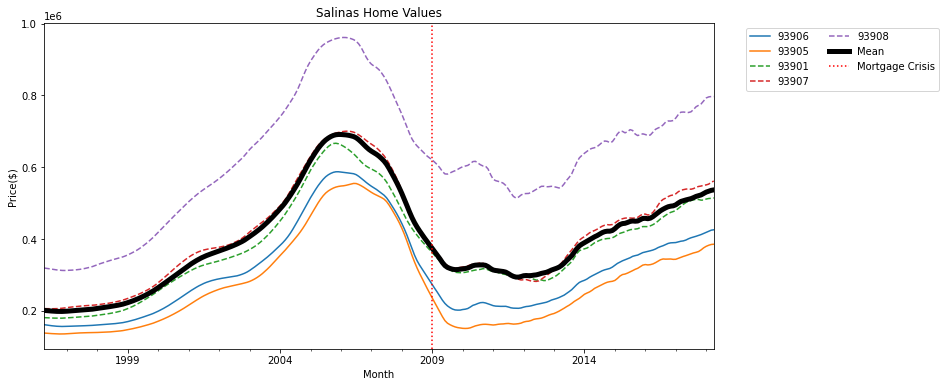

In [20]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
        crash = '01-2009'
        ax.axvline(crash, label = 'Mortgage Crisis', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'Salinas Home Values', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict3 = plot_value(salinas)

In [21]:
santa_barbara_df = df.loc[df['City'] == 'Santa Barbara']
santa_barbara_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,97124,93101,Santa Barbara,CA,Santa Maria-Santa Barbara,Santa Barbara,2983,1996-04-01,224800.0
1996-04-01,97127,93105,Santa Barbara,CA,Santa Maria-Santa Barbara,Santa Barbara,3964,1996-04-01,323000.0
1996-04-01,97126,93103,Santa Barbara,CA,Santa Maria-Santa Barbara,Santa Barbara,6130,1996-04-01,325600.0
1996-04-01,97132,93110,Santa Barbara,CA,Santa Maria-Santa Barbara,Santa Barbara,6620,1996-04-01,364600.0
1996-04-01,97131,93109,Santa Barbara,CA,Santa Maria-Santa Barbara,Santa Barbara,8056,1996-04-01,288900.0


In [22]:
santa_barbara = {}
for zipcode in santa_barbara_df['RegionName'].unique():
    temp = santa_barbara_df.groupby('RegionName').get_group(zipcode)
    santa_barbara[zipcode] = temp.resample('MS').asfreq()
    

[93101, 93105, 93103, 93110, 93109]


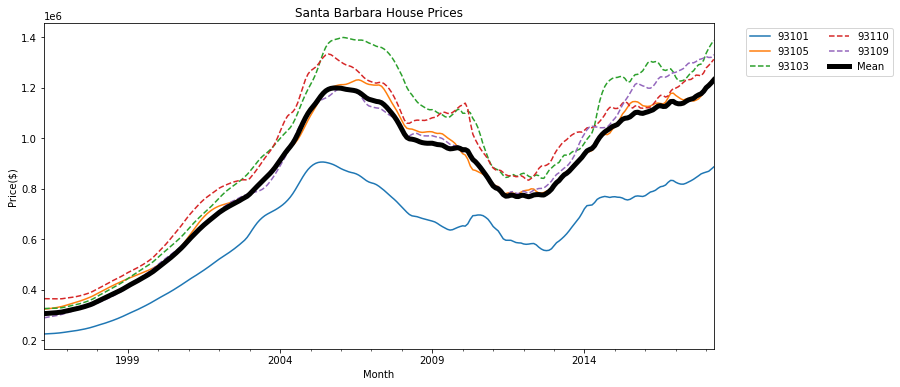

In [23]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
#         crash = '01-2009'
#         ax.axvline(crash, label = 'Mortgage Crisis', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'Santa Barbara House Prices', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict4 = plot_value(santa_barbara)

In [24]:
san_diego_df = df.loc[df['City'] == 'San Diego']
san_diego_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,96667,92126,San Diego,CA,San Diego,San Diego,165,1996-04-01,157000.0
1996-04-01,96651,92109,San Diego,CA,San Diego,San Diego,209,1996-04-01,247700.0
1996-04-01,96643,92101,San Diego,CA,San Diego,San Diego,212,1996-04-01,147000.0
1996-04-01,96646,92104,San Diego,CA,San Diego,San Diego,413,1996-04-01,130000.0
1996-04-01,96657,92115,San Diego,CA,San Diego,San Diego,414,1996-04-01,139900.0


In [25]:
san_diego = {}
for zipcode in san_diego_df['RegionName'].unique():
    temp = san_diego_df.groupby('RegionName').get_group(zipcode)
    san_diego[zipcode] = temp.resample('MS').asfreq()
    

[92126, 92109, 92101, 92104, 92115, 92154, 92105, 92122, 92117, 92130, 92128, 92037, 92103, 92129, 92114, 92111, 92116, 92127, 92102, 92107, 92113, 92108, 92131, 92110, 92120, 92123, 92124, 92139, 92119, 92106, 92173, 78384, 92121]


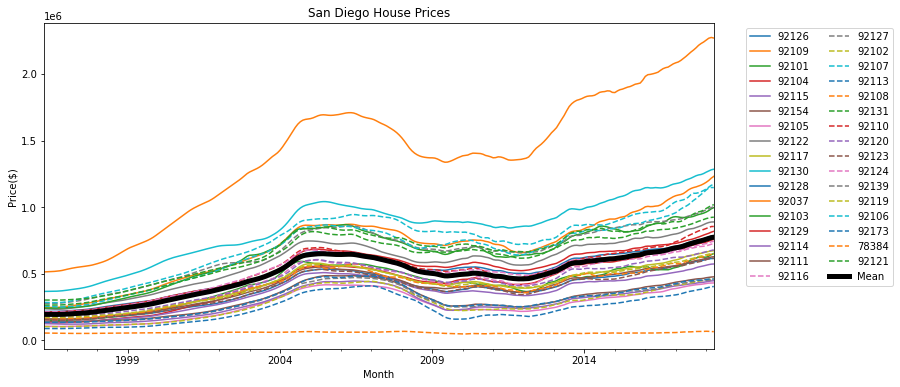

In [26]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
#         crash = '01-2009'
#         ax.axvline(crash, label = 'Mortgage Crisis', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'San Diego House Prices', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict5 = plot_value(san_diego)

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

In [28]:
def plot_acf_pacf(ts, figsize = (10,8), lags = 20):
    '''The purpose of this function is to plot the ACF (Akaike Correlation Function)
    and the PACF Partial autocorrelation function from the timeseries dataframe'''
    
    
    fig,ax = plt.subplots(nrows = 3, figsize = figsize)
    ts.plot(ax=ax[0])
    plot_acf(ts, ax=ax[1], lags = lags)
    plot_pacf(ts, ax=ax[2], lags = lags)
    plt.tight_layout()
    
    plt.suptitle(f'Zipcode: {ts.name}', y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks = lags, integer = True))
        a.xaxis.grid()
              

In [29]:
zips5 = list(ts_dict5.keys())
zips5

[92126,
 92109,
 92101,
 92104,
 92115,
 92154,
 92105,
 92122,
 92117,
 92130,
 92128,
 92037,
 92103,
 92129,
 92114,
 92111,
 92116,
 92127,
 92102,
 92107,
 92113,
 92108,
 92131,
 92110,
 92120,
 92123,
 92124,
 92139,
 92119,
 92106,
 92173,
 78384,
 92121]

In [30]:
zips4 = list(ts_dict4.keys())
zips4

[93101, 93105, 93103, 93110, 93109]

In [31]:
zips3 = list(ts_dict3.keys())
zips3

[93906, 93905, 93901, 93907, 93908]

In [32]:
zips2 = list(ts_dict2.keys())
zips2

[93277, 93291, 93292]

In [33]:
zips1 = list(ts_dict1.keys())
zips1

[95823,
 95831,
 95822,
 95833,
 95843,
 95835,
 95820,
 95842,
 95838,
 95660,
 95834,
 95816,
 95818,
 95824,
 95829,
 95841,
 95819,
 95817,
 95811,
 95832,
 95815]